In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras import layers, callbacks

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df = pd.read_csv('Mastercard_stock_history.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
1,2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2,2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
3,2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
4,2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


In [56]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3872 entries, 2006-05-25 to 2021-10-11
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3872 non-null   float64
 1   High          3872 non-null   float64
 2   Low           3872 non-null   float64
 3   Close         3872 non-null   float64
 4   Volume        3872 non-null   int64  
 5   Dividends     3872 non-null   float64
 6   Stock Splits  3872 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 242.0 KB
None


In [57]:
print(df.describe())

              Open         High          Low        Close        Volume  \
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03   
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07   
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07   
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05   
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06   
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06   
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07   
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08   

         Dividends  Stock Splits  
count  3872.000000   3872.000000  
mean      0.002329      0.002583  
std       0.025851      0.160706  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      0.000000  
max       0.440000     10.000000  


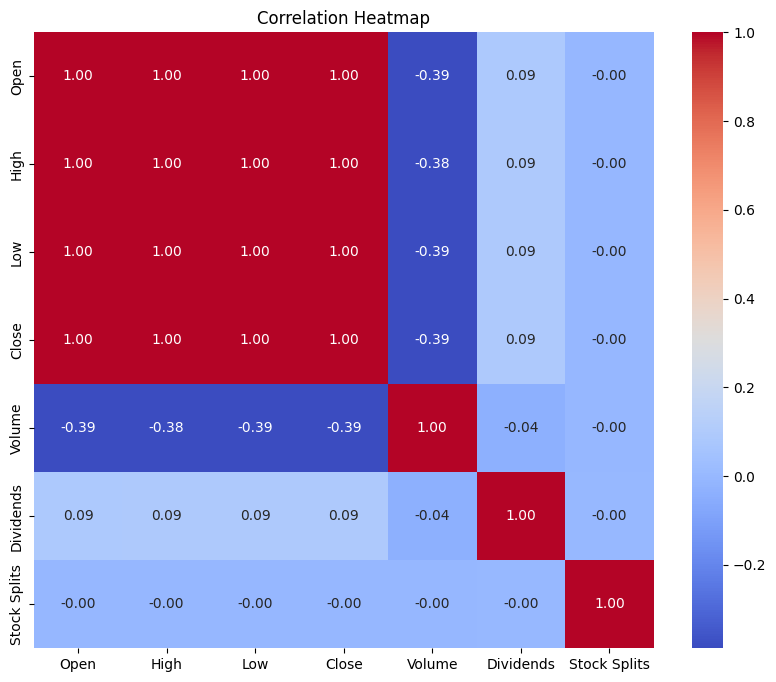

In [58]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [5]:
df.index = pd.to_datetime(df['Date'])
df.drop(columns=['Date'], inplace=True)

In [6]:
train = df[(df.index.year<2021) & (df.index.year>=2016)]
test = df[df.index.year>=2021]

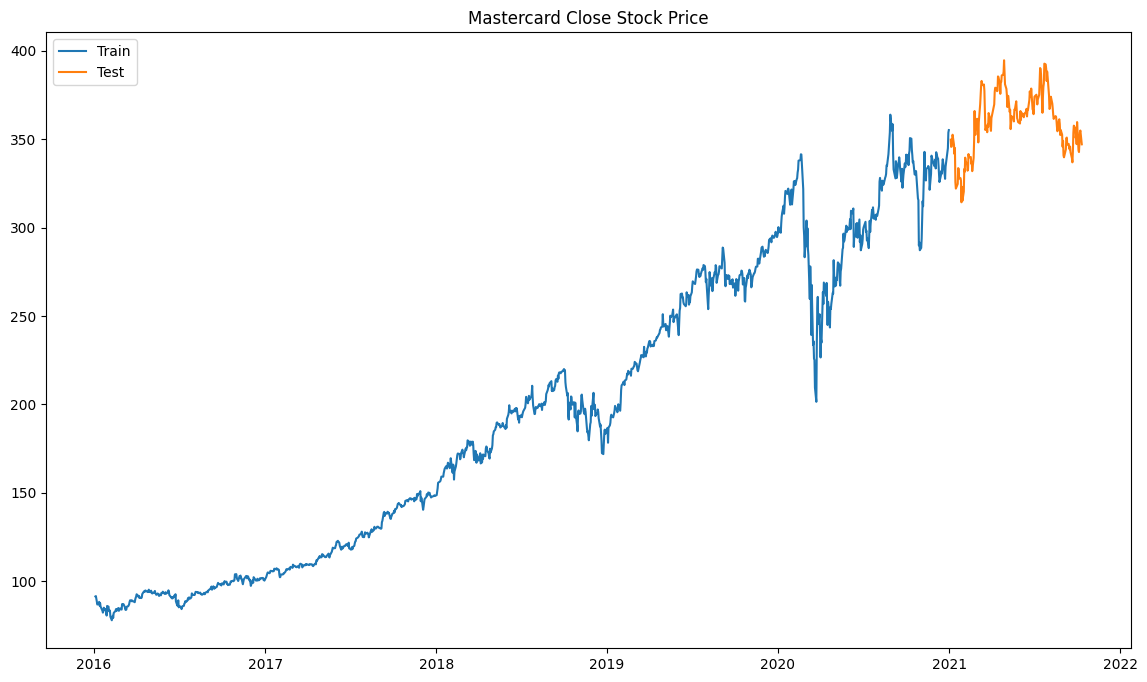

In [7]:
plt.figure(figsize=(14,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.legend()
plt.title('Mastercard Close Stock Price')
plt.show()

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train['Close'].values.reshape(-1, 1))

In [9]:
X_train = []
y_train = []
for i in range(80,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-80:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [26]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)),
    layers.Dropout(0.2),

    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),

    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),

    layers.LSTM(units=50),
    layers.Dropout(0.2),

    layers.Dense(units=1),
])

model.compile(optimizer='adam',loss='mse', metrics=['mse', 'mae', 'mape'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 80, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 80, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 80, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 80, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 80, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 80, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [45]:
early_stopping = callbacks.EarlyStopping(
    patience=6,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(X_train,y_train,epochs=50,batch_size=24, callbacks=[early_stopping])

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0294 - mape: 11.3855

50/50 [==============================] - 7s 132ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0294 - mape: 11.3855
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022 - mae: 0.0323 - mape: 11.7670

50/50 [==============================] - 6s 116ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0323 - mape: 11.7670
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0302 - mape: 11.1754

50/50 [==============================] - 7s 131ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0302 - mape: 11.1754
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0300 - mape: 12.4944

50/50 [==============================] - 6s 115ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0300 - mape: 12.4944
Epoch 5/50
50/50 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0304 - mape: 11.8687

50/50 [==============================] - 7s 131ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0304 - mape: 11.8687
Epoch 6/50
50/50 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0299 - mape: 11.5007

50/50 [==============================] - 6s 116ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0299 - mape: 11.5007
Epoch 7/50
50/50 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0280 - mape: 11.7027

50/50 [==============================] - 7s 130ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0280 - mape: 11.7027
Epoch 8/50
50/50 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0280 - mape: 11.6776

50/50 [==============================] - 6s 125ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0280 - mape: 11.6776
Epoch 9/50
50/50 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0291 - mape: 11.4447

50/50 [==============================] - 6s 130ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0291 - mape: 11.4447
Epoch 10/50
50/50 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0285 - mape: 11.3013

50/50 [==============================] - 6s 115ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0285 - mape: 11.3013
Epoch 11/50
50/50 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0282 - mape: 12.0503

50/50 [==============================] - 7s 131ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0282 - mape: 12.0503
Epoch 12/50
50/50 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0275 - mape: 11.4992

50/50 [==============================] - 6s 115ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0275 - mape: 11.4992
Epoch 13/50
50/50 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0278 - mape: 11.5565

50/50 [==============================] - 7s 131ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0278 - mape: 11.5565
Epoch 14/50
50/50 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0295 - mape: 11.6856

50/50 [==============================] - 6s 115ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0295 - mape: 11.6856
Epoch 15/50
50/50 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0283 - mape: 11.7289

50/50 [==============================] - 7s 131ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0283 - mape: 11.7289
Epoch 16/50
50/50 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mae: 0.0269 - mape: 11.3924

50/50 [==============================] - 6s 116ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0269 - mape: 11.3924
Epoch 17/50
50/50 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0290 - mape: 12.5349

50/50 [==============================] - 7s 131ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0290 - mape: 12.5349
Epoch 18/50
50/50 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0287 - mape: 12.4413

50/50 [==============================] - 6s 115ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0287 - mape: 12.4413
Epoch 19/50
50/50 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0282 - mape: 11.9642

50/50 [==============================] - 7s 132ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0282 - mape: 11.9642
Epoch 20/50
50/50 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mae: 0.0271 - mape: 11.7455

50/50 [==============================] - 6s 115ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0271 - mape: 11.7455
Epoch 21/50
50/50 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0291 - mape: 11.8554

50/50 [==============================] - 7s 132ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0291 - mape: 11.8554
Epoch 22/50
50/50 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0321 - mape: 13.9383

50/50 [==============================] - 6s 117ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0321 - mape: 13.9383
Epoch 23/50
50/50 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0275 - mape: 11.8178

50/50 [==============================] - 6s 129ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0275 - mape: 11.8178
Epoch 24/50
50/50 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mae: 0.0273 - mape: 11.8916

50/50 [==============================] - 6s 119ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0273 - mape: 11.8916
Epoch 25/50
50/50 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0281 - mape: 11.9583

50/50 [==============================] - 6s 126ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0281 - mape: 11.9583
Epoch 26/50
50/50 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mae: 0.0264 - mape: 11.3709

50/50 [==============================] - 6s 122ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0264 - mape: 11.3709
Epoch 27/50
50/50 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mae: 0.0271 - mape: 12.0574

50/50 [==============================] - 6s 123ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0271 - mape: 12.0574
Epoch 28/50
50/50 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0296 - mape: 12.9919

50/50 [==============================] - 6s 126ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0296 - mape: 12.9919
Epoch 29/50
50/50 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0260 - mape: 11.8343

50/50 [==============================] - 6s 118ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0260 - mape: 11.8343
Epoch 30/50
50/50 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mae: 0.0259 - mape: 11.2113

50/50 [==============================] - 6s 129ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0259 - mape: 11.2113
Epoch 31/50
50/50 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0255 - mape: 11.0505

50/50 [==============================] - 6s 117ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0255 - mape: 11.0505
Epoch 32/50
50/50 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0265 - mape: 11.9348

50/50 [==============================] - 7s 131ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0265 - mape: 11.9348
Epoch 33/50
50/50 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mae: 0.0264 - mape: 11.9905

50/50 [==============================] - 6s 115ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0264 - mape: 11.9905
Epoch 34/50
50/50 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mae: 0.0260 - mape: 11.7070

50/50 [==============================] - 7s 131ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0260 - mape: 11.7070
Epoch 35/50
50/50 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0266 - mape: 12.7796

50/50 [==============================] - 6s 116ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0266 - mape: 12.7796
Epoch 36/50
50/50 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0266 - mape: 12.4592

50/50 [==============================] - 7s 130ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0266 - mape: 12.4592
Epoch 37/50
50/50 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0261 - mape: 12.0399

50/50 [==============================] - 6s 116ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0261 - mape: 12.0399
Epoch 38/50
50/50 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0259 - mape: 12.2227

50/50 [==============================] - 7s 131ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0259 - mape: 12.2227
Epoch 39/50
50/50 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0273 - mape: 12.7107

50/50 [==============================] - 6s 116ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0273 - mape: 12.7107
Epoch 40/50
50/50 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0299 - mape: 15.5014

50/50 [==============================] - 7s 132ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0299 - mape: 15.5014
Epoch 41/50
50/50 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0275 - mape: 12.4124

50/50 [==============================] - 6s 116ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0275 - mape: 12.4124
Epoch 42/50
50/50 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0262 - mape: 11.4891

50/50 [==============================] - 7s 131ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0262 - mape: 11.4891
Epoch 43/50
50/50 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mae: 0.0253 - mape: 11.9971

50/50 [==============================] - 6s 115ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0253 - mape: 11.9971
Epoch 44/50
50/50 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mae: 0.0253 - mape: 11.5745

50/50 [==============================] - 7s 131ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0253 - mape: 11.5745
Epoch 45/50
50/50 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0249 - mape: 12.0148

50/50 [==============================] - 6s 117ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0249 - mape: 12.0148
Epoch 46/50
50/50 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0285 - mape: 13.7847

50/50 [==============================] - 7s 131ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0285 - mape: 13.7847
Epoch 47/50
50/50 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0254 - mape: 11.7507

50/50 [==============================] - 6s 116ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0254 - mape: 11.7507
Epoch 48/50
50/50 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mae: 0.0248 - mape: 11.8667

50/50 [==============================] - 7s 132ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0248 - mape: 11.8667
Epoch 49/50
50/50 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - mae: 0.0256 - mape: 12.3221

50/50 [==============================] - 6s 121ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0256 - mape: 12.3221
Epoch 50/50
50/50 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mae: 0.0268 - mape: 12.5092

50/50 [==============================] - 7s 132ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0268 - mape: 12.5092


In [46]:
history_frame = pd.DataFrame(history.history)

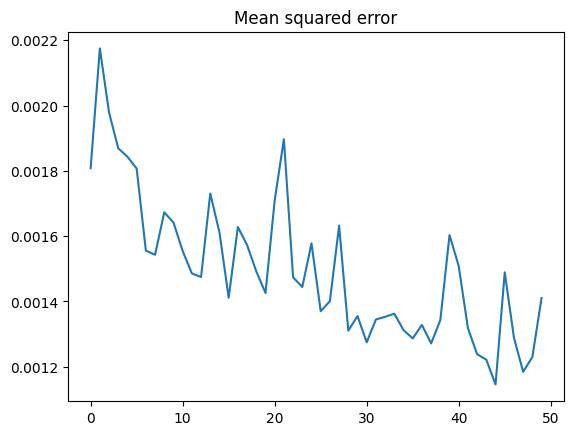

In [47]:
plt.plot(history_frame.loc[:, ['mse']])
plt.title('Mean squared error')
plt.show()

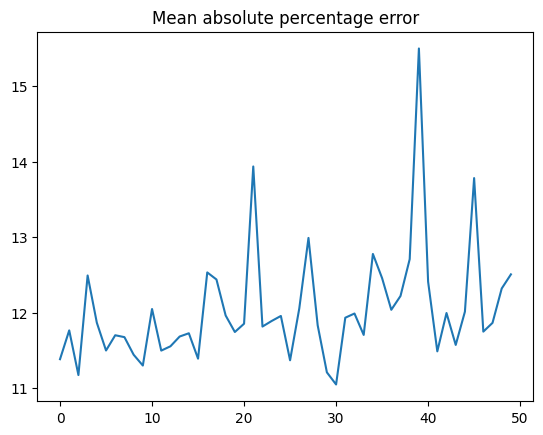

In [48]:
plt.plot(history_frame.loc[:, ['mape']])
plt.title('Mean absolute percentage error')
plt.show()

In [49]:
dataset_total = df['Close']
inputs = dataset_total[len(dataset_total)-len(test['Close'].values) - 80:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [50]:
X_test = []
for i in range(80,len(inputs)):
    X_test.append(inputs[i-80:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 [==============================] - 0s 34ms/step


In [51]:
predictions = pd.DataFrame()
predictions['Actuals'] = test['Close']
predictions['Predictions'] = predicted_stock_price

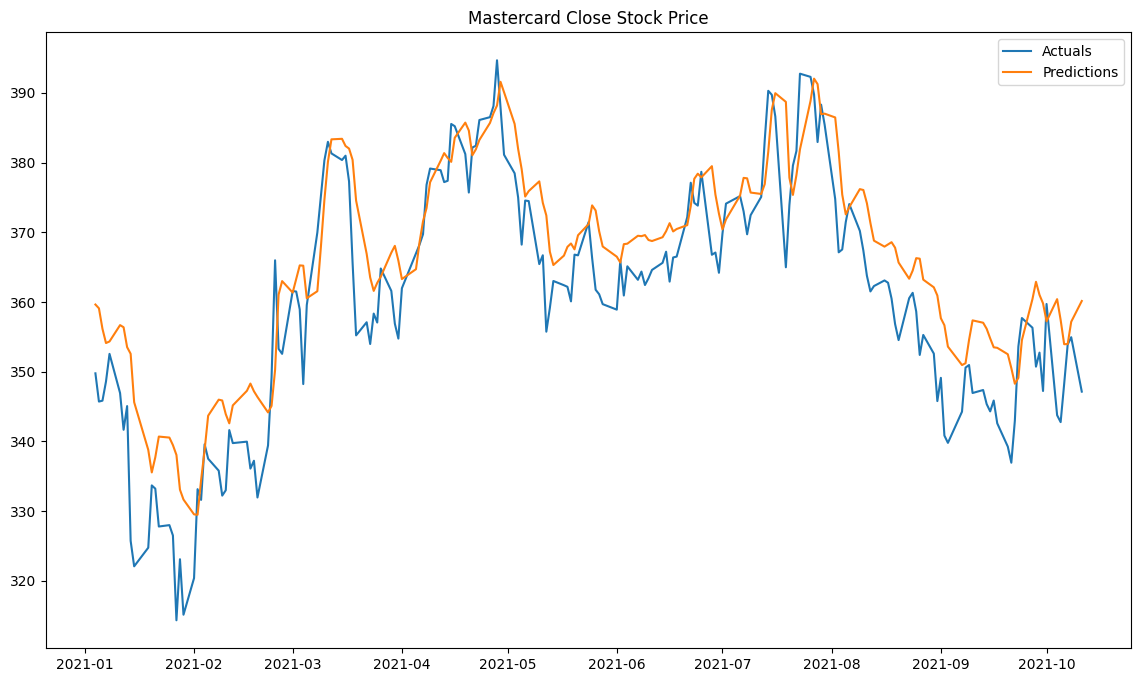

In [52]:
plt.figure(figsize=(14,8))
plt.title('Mastercard Close Stock Price')
plt.plot(predictions['Actuals'], label='Actuals')
plt.plot(predictions['Predictions'], label='Predictions')
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'predicted_stock_price' and 'test' are defined
y_true = test['Close'].values
mse = mean_squared_error(y_true, predicted_stock_price)
mae = mean_absolute_error(y_true, predicted_stock_price)
r2 = r2_score(y_true, predicted_stock_price)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared: {r2}')


Mean Squared Error (MSE): 75.6431869074989
Mean Absolute Error (MAE): 7.01433825370593
R-squared: 0.7430744178559578
